# Load Data from File

In [8]:
from pyspark.sql.types import *

raw_data = sc.textFile('/user/cloudera/data/bike-sharing/hour_nohead.csv')
column_data = raw_data.map(lambda x: x.split(','))

schema = StructType([
    StructField('row_id',StringType(),True),
    StructField('date',StringType(), True),
    StructField('season',StringType(), True),
    StructField('year',StringType(), True),
    StructField('month',StringType(), True),
    StructField('hour',StringType(), True),
    StructField('holiday',StringType(), True),
    StructField('weekday',StringType(), True),
    StructField('workingday',StringType(), True),
    StructField('weather',StringType(), True),
    StructField('temperature',StringType(), True),
    StructField('apparent_temperature',StringType(), True),
    StructField('humidity',StringType(), True),
    StructField('wind_speed',StringType(), True),
    StructField('casual',StringType(), True),
    StructField('registered',StringType(), True),
    StructField('counter',StringType(), True)
    ])
structured_data = sqlContext.createDataFrame(column_data, schema)    
data = structured_data.select(
    structured_data.row_id.cast('int'),
    structured_data.date.cast('string'),
    structured_data.season.cast('int'),
    structured_data.year.cast('int'),
    structured_data.month.cast('int'),
    structured_data.hour.cast('int'),
    structured_data.holiday.cast('int'),
    structured_data.weekday.cast('int'),
    structured_data.workingday.cast('int'),
    structured_data.weather.cast('int'),
    structured_data.temperature.cast('double'),
    structured_data.apparent_temperature.cast('double'),
    structured_data.humidity.cast('double'),
    structured_data.wind_speed.cast('double'),
    structured_data.casual.cast('int'),
    structured_data.registered.cast('int'),
    structured_data.counter.cast('int')
    )

# Prepare Data

In [9]:
from pyspark.sql.functions import *

ddata = data.select(
        data.date,
        unix_timestamp(data.date, "yyyy-MM-dd").alias('ts'),
        data.season.cast("double"),
        data.year.cast("double"),
        data.month.cast("double"),
        data.hour.cast("double"),
        data.holiday.cast("double"),
        data.weekday.cast("double"),
        data.workingday.cast("double"),
        data.weather.cast("double"),
        data.temperature,
        data.apparent_temperature,
        data.humidity,
        data.wind_speed,
        data.counter.cast("double")
    )

# Make some Pictures

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

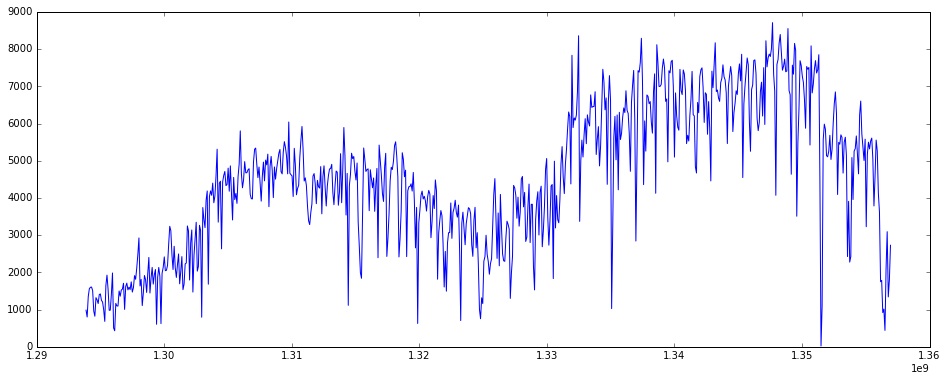

In [24]:
tmp = ddata\
    .groupBy('ts').sum('counter') \
    .orderBy('ts')

pdf = tmp.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf['ts'],pdf['sum(counter)'])

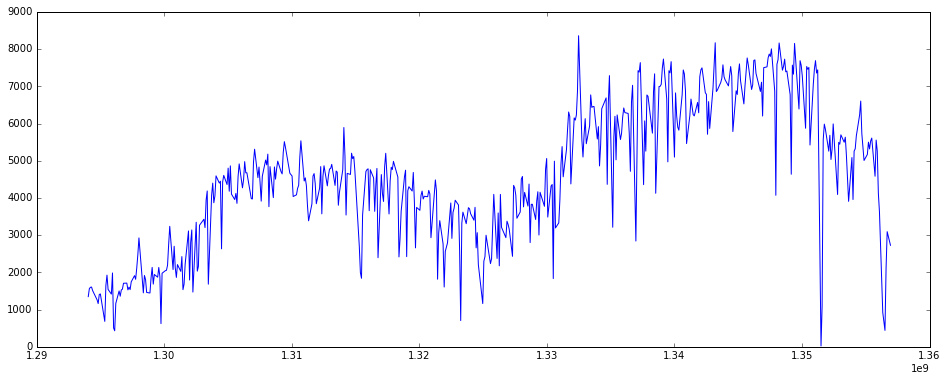

In [26]:
tmp = ddata \
    .filter(ddata.workingday == 1) \
    .groupBy('ts').sum('counter') \
    .orderBy('ts')
    
pdf = tmp.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf['ts'],pdf['sum(counter)'])

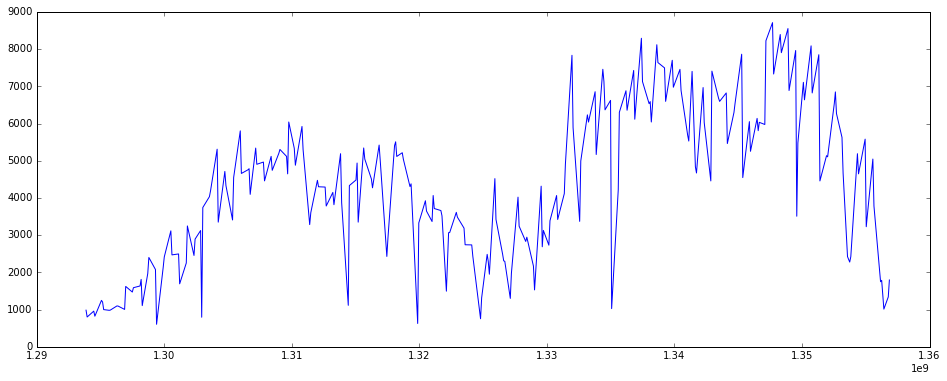

In [27]:
tmp = ddata \
    .filter(ddata.workingday == 0) \
    .groupBy('ts').sum('counter') \
    .orderBy('ts')
    
pdf = tmp.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf['ts'],pdf['sum(counter)'])    

# Initial Statistics

In [28]:
schema = ddata.schema

for field in schema.fields:
    if field.dataType == DoubleType():
        rdd = ddata.select(col(field.name)).rdd.map(lambda row: row[0])
        print field.name + ': ' + str(rdd.stats())
    else:
        print field.name + ': ' + str(field.dataType)

date: StringType
ts: LongType
season: (count: 17379, mean: 2.50163991024, stdev: 1.10688629256, max: 4.0, min: 1.0)
year: (count: 17379, mean: 0.502560561597, stdev: 0.499993443481, max: 1.0, min: 0.0)
month: (count: 17379, mean: 6.53777547615, stdev: 3.43867677753, max: 12.0, min: 1.0)
hour: (count: 17379, mean: 11.5467518269, stdev: 6.91420616251, max: 23.0, min: 0.0)
holiday: (count: 17379, mean: 0.0287703550262, stdev: 0.167160466911, max: 1.0, min: 0.0)
weekday: (count: 17379, mean: 3.00368260544, stdev: 2.00571374852, max: 6.0, min: 0.0)
workingday: (count: 17379, mean: 0.682720524771, stdev: 0.465417242727, max: 1.0, min: 0.0)
weather: (count: 17379, mean: 1.425283388, stdev: 0.639338482965, max: 4.0, min: 1.0)
temperature: (count: 17379, mean: 0.496987168422, stdev: 0.192550581262, max: 1.0, min: 0.02)
apparent_temperature: (count: 17379, mean: 0.475775102135, stdev: 0.171845271373, max: 1.0, min: 0.0)
humidity: (count: 17379, mean: 0.627228839404, stdev: 0.192924283323, max: 1

# Extract Vectors for Regression

In [31]:
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors

def extract_vector(row, cols):
    return Vectors.dense([row[c] for c in cols])

print extract_vector(Row('name','age')('Bob',23), [1])

[23.0]


In [33]:
cols = [1,2,3,4,5,6,7,8,9,10,11,12,13]
rdd = ddata.rdd.map(lambda row: [extract_vector(row, cols), row[14]])
features_labels = sqlContext.createDataFrame(rdd, ['features','counter'])

features_labels.limit(10).toPandas()


,features,counter
0,"[1293868800.0, 1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0...",16.0
1,"[1293868800.0, 1.0, 0.0, 1.0, 1.0, 0.0, 6.0, 0...",40.0
2,"[1293868800.0, 1.0, 0.0, 1.0, 2.0, 0.0, 6.0, 0...",32.0
3,"[1293868800.0, 1.0, 0.0, 1.0, 3.0, 0.0, 6.0, 0...",13.0
4,"[1293868800.0, 1.0, 0.0, 1.0, 4.0, 0.0, 6.0, 0...",1.0
5,"[1293868800.0, 1.0, 0.0, 1.0, 5.0, 0.0, 6.0, 0...",1.0
6,"[1293868800.0, 1.0, 0.0, 1.0, 6.0, 0.0, 6.0, 0...",2.0
7,"[1293868800.0, 1.0, 0.0, 1.0, 7.0, 0.0, 6.0, 0...",3.0
8,"[1293868800.0, 1.0, 0.0, 1.0, 8.0, 0.0, 6.0, 0...",8.0
9,"[1293868800.0, 1.0, 0.0, 1.0, 9.0, 0.0, 6.0, 0...",14.0


# Split Data into Training and Test Set

In [34]:
train_data, test_data = features_labels.randomSplit([0.8,0.2], seed=0)
print train_data.count()
print test_data.count()

13883
3496


# Perform Linear Regression

In [35]:
from pyspark.ml.regression import *

regression = LinearRegression(featuresCol='features', labelCol='counter', predictionCol='prediction')
model = regression.fit(train_data)

In [36]:
print model.coefficients
print model.intercept

[-2.96086160434e-06,18.5980267255,174.004590735,8.01419186576,7.77977847647,-19.7530579268,1.91971963118,2.75057325068,-4.8076582427,92.2710193043,225.585224977,-194.836674999,46.9052693528]
3798.28681399


# Perform Prediction

In [38]:
prediction = model.transform(test_data)
prediction.limit(10).toPandas()

,features,counter,prediction
0,"[1293868800.0, 1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0...",16.0,-70.083435
1,"[1293868800.0, 1.0, 0.0, 1.0, 3.0, 0.0, 6.0, 0...",13.0,-35.053899
2,"[1293868800.0, 1.0, 0.0, 1.0, 5.0, 0.0, 6.0, 0...",1.0,-26.934520
3,"[1293868800.0, 1.0, 0.0, 1.0, 22.0, 0.0, 6.0, ...",28.0,123.541648
4,"[1293868800.0, 1.0, 0.0, 1.0, 23.0, 0.0, 6.0, ...",39.0,162.288590
5,"[1293955200.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0...",9.0,-47.466256
6,"[1293955200.0, 1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0...",6.0,-21.672917
7,"[1293955200.0, 1.0, 0.0, 1.0, 8.0, 0.0, 0.0, 0...",8.0,42.855390
8,"[1293955200.0, 1.0, 0.0, 1.0, 15.0, 0.0, 0.0, ...",74.0,52.394306
9,"[1293955200.0, 1.0, 0.0, 1.0, 17.0, 0.0, 0.0, ...",65.0,125.727759


# Evaluate Model

In [40]:
from pyspark.ml.evaluation import *
from pyspark.sql.functions import stddev

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='counter', metricName='rmse')
print evaluator.evaluate(prediction)

144.765415265


# Use VectorAssembler

In [41]:
from pyspark.ml.feature import *

tx = VectorAssembler(inputCols=['season','year','month','hour','holiday','weekday','workingday','weather','temperature','apparent_temperature','humidity','wind_speed'],outputCol='features')
td = tx.transform(ddata)

td.printSchema()

root
 |-- date: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- season: double (nullable = true)
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- hour: double (nullable = true)
 |-- holiday: double (nullable = true)
 |-- weekday: double (nullable = true)
 |-- workingday: double (nullable = true)
 |-- weather: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- apparent_temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- counter: double (nullable = true)
 |-- features: vector (nullable = true)



In [42]:
train_data, test_data = ddata.randomSplit([0.8,0.2], seed=0)
print train_data.count()
print test_data.count()

13883
3496


In [43]:
asm = VectorAssembler(inputCols=['season','year','month','hour','holiday','weekday','workingday','weather','temperature','apparent_temperature','humidity','wind_speed'],outputCol='features')
regression = LinearRegression(featuresCol='features', labelCol='counter', predictionCol='prediction')
model = regression.fit(asm.transform(train_data))

In [44]:
prediction = model.transform(asm.transform(test_data))

prediction.limit(10).toPandas()

,date,ts,season,year,month,hour,holiday,weekday,workingday,weather,temperature,apparent_temperature,humidity,wind_speed,counter,features,prediction
0,2011-01-01,1293868800,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,16.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.24,...",-73.445122
1,2011-01-01,1293868800,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,13.0,"[1.0, 0.0, 1.0, 3.0, 0.0, 6.0, 0.0, 1.0, 0.24,...",-38.397224
2,2011-01-01,1293868800,1.0,0.0,1.0,5.0,0.0,6.0,0.0,2.0,0.24,0.2576,0.75,0.0896,1.0,"[1.0, 0.0, 1.0, 5.0, 0.0, 6.0, 0.0, 2.0, 0.24,...",-30.330573
3,2011-01-01,1293868800,1.0,0.0,1.0,22.0,0.0,6.0,0.0,2.0,0.40,0.4091,0.94,0.2239,28.0,"[1.0, 0.0, 1.0, 22.0, 0.0, 6.0, 0.0, 2.0, 0.4,...",119.961386
4,2011-01-01,1293868800,1.0,0.0,1.0,23.0,0.0,6.0,0.0,2.0,0.46,0.4545,0.88,0.2985,39.0,"[1.0, 0.0, 1.0, 23.0, 0.0, 6.0, 0.0, 2.0, 0.46...",158.693576
5,2011-01-02,1293955200,1.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.42,0.4242,1.00,0.2836,9.0,"[1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.42,...",-50.734547
6,2011-01-02,1293955200,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,6.0,"[1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.46,...",-24.918390
7,2011-01-02,1293955200,1.0,0.0,1.0,8.0,0.0,0.0,0.0,3.0,0.40,0.4091,0.71,0.2239,8.0,"[1.0, 0.0, 1.0, 8.0, 0.0, 0.0, 0.0, 3.0, 0.4, ...",39.812573
8,2011-01-02,1293955200,1.0,0.0,1.0,15.0,0.0,0.0,0.0,3.0,0.34,0.3333,0.81,0.1642,74.0,"[1.0, 0.0, 1.0, 15.0, 0.0, 0.0, 0.0, 3.0, 0.34...",49.199213
9,2011-01-02,1293955200,1.0,0.0,1.0,17.0,0.0,0.0,0.0,1.0,0.34,0.3333,0.57,0.1940,65.0,"[1.0, 0.0, 1.0, 17.0, 0.0, 0.0, 0.0, 1.0, 0.34...",122.497711


In [45]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='counter', metricName='rmse')
print evaluator.evaluate(prediction)


144.699539343


# Make New Pictures of Regression

(1293868800, 1356940800)

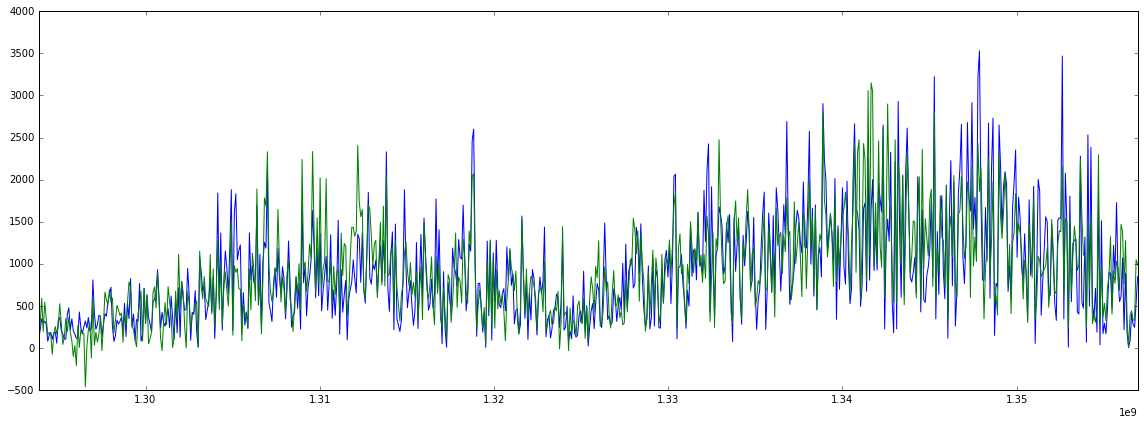

In [58]:
tmp = prediction \
    .groupBy('ts').agg({'counter':'sum', 'prediction':'sum'}) \
    .orderBy('ts')
    
pdf = tmp.toPandas()

min_ts,max_ts = prediction.agg(min('ts'), max('ts')).collect()[0]

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k', tight_layout=True)
plt.plot(pdf['ts'],pdf['sum(counter)'])
plt.plot(pdf['ts'],pdf['sum(prediction)'])    
axes = plt.gca()
axes.set_xlim([min_ts,max_ts])